# Random Forest
Total dataset size: 134 samples <br>
Training set: 134 samples

Features used (after importance analysis):
- LTA precipitation (mmpa)
- LTA wet days
- LTA_PET_mm
- Aridity idx
- NDVI
- DEM
- LTA soil moisture - 10 cm (m3 m-3) 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
from utils import getAllCoordinates
import json

# Prepare all BGS points as training points

# read file (data + coordinates)
file = pd.read_csv('poc_ext.csv')
# OMIT ZERO RECHARGE SAMPLES
file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa']< 800]
# drop unimportant columns
data = file.drop(columns=['ID', 'Lat', 'Long', 'Aquifer_group', 'Soil_group', 'Landcover', 'Landcover_ext','LTA_GPCC_mmpa', 'LTA_CHIRPS_mmpa', 'SM10_kgm2', 'LTA_WD_days', 'DEM'])
# Labels are the values we want to predict
labels = np.log10(data['Recharge_mmpa'])
#labels = data['Recharge_mmpa']
data = data.drop('Recharge_mmpa', axis = 1)
# Add for reference
data['ID'] = file['ID']
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

file[file['Recharge_mmpa'] == 0.1]

,Recharge_mmpa,LTA_CHIRPS_mmpa,LTA_GPCC_mmpa,LTA_P_mmpa,LTA_WD_days,LTA_PET_mm,Aridity,NDVI,Aquifer_group,Soil_group,Landcover_ext,Landcover,DEM,SM10_m3m3,SM10_kgm2,Lat,Long,ID


In [2]:
correlation_matrix = data.corr()
correlation_matrix

,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,SM10_m3m3,ID
LTA_P_mmpa,1.000000,-0.534214,0.973336,0.843510,0.932252,-0.050985
LTA_PET_mm,-0.534214,1.000000,-0.625877,-0.696296,-0.580156,0.009623
Aridity,0.973336,-0.625877,1.000000,0.840664,0.926042,-0.045108
NDVI,0.843510,-0.696296,0.840664,1.000000,0.812939,0.016159
SM10_m3m3,0.932252,-0.580156,0.926042,0.812939,1.000000,-0.020052
ID,-0.050985,0.009623,-0.045108,0.016159,-0.020052,1.000000


In [3]:
data

,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,SM10_m3m3,ID
0,1234.743356,1265.000000,0.977426,0.548899,0.317942,1
1,555.876675,1386.030028,0.403442,0.417538,0.210401,2
2,1376.716688,1337.440024,1.029575,0.687945,0.312940,3
3,518.196676,1590.610029,0.326188,0.268559,0.229384,4
4,1344.580024,1298.693353,1.038857,0.593882,0.330358,5
...,...,...,...,...,...,...
129,655.280013,1356.070025,0.486649,0.403724,0.323871,130
130,816.720013,1266.233355,0.648767,0.479056,0.227937,131
131,510.140009,1922.536704,0.265403,0.327490,0.194245,132
132,1215.073356,1149.026683,1.058098,0.447078,0.279276,133


# Run RF for the whole domain

In [7]:
# get all coordinates of the smallest raster - workaround as rasters have slightly different shapes
coords, T0, out_shape = getAllCoordinates('Recharge_files/Africa_bgs_LTA_AnnPrecip.tif')

In [8]:
# read rasters
pet_src = rasterio.open('Recharge_files/Africa_bgs_LTA_AnnPET.tif')
p_src = rasterio.open('Recharge_files/Africa_bgs_LTA_AnnPrecip.tif')
ndvi_src = rasterio.open('Recharge_files/Africa_NDVI.tif')
ai_src = rasterio.open('Recharge_files/Africa_bgs_aridity_index.tif')
sm_src = rasterio.open('Low_res_data_05/LTA_FLDAS_Soil_moisture_Afr_05.tif')

# get raster values at 0.5x0.5 grid + flatten
pet_samples = [item for sublist in list(pet_src.sample(coords)) for item in sublist]
p_samples = [item for sublist in list(p_src.sample(coords)) for item in sublist]
ndvi_samples = [item for sublist in list(ndvi_src.sample(coords)) for item in sublist]
ai_samples = [item for sublist in list(ai_src.sample(coords)) for item in sublist]
sm_samples = [item for sublist in list(sm_src.sample(coords)) for item in sublist]

In [9]:
# combine predictors in a dataframe
raw_ds = pd.DataFrame({'LTA_P_mmpa': p_samples, 'LTA_PET_mm': pet_samples,
                       'Aridity': ai_samples, 'NDVI': ndvi_samples,
                       #'Landcover': lc_samples,
                       #'DEM': dem_samples,
                       'SM10_m3m3': sm_samples})

# take rows with valid predictor data (land only)
filtered_ds = raw_ds[(raw_ds['LTA_P_mmpa'] >= -1000)
                     & (raw_ds['LTA_PET_mm'] >= -1000) & (raw_ds['Aridity'] >= -1000) & (raw_ds['SM10_m3m3'] > 0)
                     # & (raw_ds['Landcover'] > 0)
                     # & (raw_ds['DEM'] >= -1000)
                     & (raw_ds['NDVI'] >= -1000)]

# convert dataframe to numpy array
domain_features = np.array(filtered_ds)

params = {'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 0.33,
 'max_depth': 80,
 'bootstrap': True}

# # optimised hyperparameters for RF with zero-recharge points
# params = {'n_estimators': 2000,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 0.33,
#  'max_depth': 10,
#  'bootstrap': True}

# apply random forest
# instantiate model
final_rf = RandomForestRegressor(**params, oob_score=True)

In [10]:
# train the model on entire BGS dataset
final_rf.fit(features[:,:-1], labels)
# use the forest's predict method on the whole domain
pred_recharge = final_rf.predict(domain_features)
# apply to training set again
train_predictions = final_rf.predict(features[:,:-1])

In [11]:
print(f'OOB score {final_rf.oob_score_}')

OOB score 0.6844204513170282


In [12]:
# merge with the features dataframe and back transform
filtered_ds['pred_recharge_mmpa'] = 10**pred_recharge
# fill gaps in the dataframe - revert to 0.5x0.5 grid
reindx_ds = filtered_ds.reindex(range(len(raw_ds)), fill_value=-9999)
recharge_grid = np.array(reindx_ds['pred_recharge_mmpa']).reshape(out_shape)

# attempt to save to a raster
# config
out_meta = {'driver': 'GTiff', "dtype": 'float32', "height": recharge_grid.shape[0], "width": recharge_grid.shape[1],
            "count": 1, "transform": T0, 'nodata': -9999, 'crs': rasterio.crs.CRS({"init": "epsg:4326"})}

#output = np.concatenate((recharge_grid[np.newaxis, :, :], diff[np.newaxis, :, :]), axis=0)

# save
with rasterio.open("Low_res_data_05/RF_recharge.tif", "w", **out_meta) as dest:
    dest.write(recharge_grid[np.newaxis, :, :])

<ipython-input-12-342f8dd9e9da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ds['pred_recharge_mmpa'] = 10**pred_recharge


In [13]:
# Get numerical feature importances
importances = list(final_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most Aimportant first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: LTA_P_mmpa           Importance: 0.24
Variable: SM10_m3m3            Importance: 0.23
Variable: Aridity              Importance: 0.21
Variable: NDVI                 Importance: 0.19
Variable: LTA_PET_mm           Importance: 0.12


In [14]:
10**np.max(pred_recharge)

277.9571519465418

In [15]:
# compare BGS linear model and random forest
point_coords = [(i,j) for (i,j) in zip(file['Long'], file['Lat'])]
obs = file['Recharge_mmpa']
rf_rech_src = rasterio.open('Low_res_data_05/RF_recharge.tif')
bgs_rech_src = rasterio.open('139265/Africa_Recharge_Map/Africa_recharge.tif')
rf_rech_samples = [item for sublist in list(rf_rech_src.sample(point_coords, indexes=1)) for item in sublist]
bgs_rech_samples = [item for sublist in list(bgs_rech_src.sample(point_coords)) for item in sublist]

summary = pd.DataFrame({'Coords': point_coords, 'Observations': obs, 'RF recharge': rf_rech_samples, 
              'BGS recharge': bgs_rech_samples})

print(summary)
summary.to_csv("summary_z.csv")

              Coords  Observations  RF recharge  BGS recharge
0       (4.48, 8.49)         253.0   183.010422    139.130249
1    (30.09, -20.27)          22.0    21.970335     25.397594
2      (32.96, 0.46)         245.0   152.603012    133.193283
3     (39.82, 13.54)         185.0    43.747753     63.007080
4         (2.3, 6.5)         120.0   176.307388    125.447845
..               ...           ...          ...           ...
129    (27.7, -26.0)         100.0    72.549965     39.552135
130  (30.55, -17.71)          80.0    84.424156     59.158382
131   (-17.0, 14.72)           8.0    19.252087     20.644716
132     (38.64, 9.4)         160.0   150.166214    141.219238
133   (33.74, -5.96)          41.0    55.480339     42.370590

[127 rows x 4 columns]


In [16]:
# problem: some observations are outside of the domain!
print(summary[(summary['BGS recharge'] < 0) | (summary['RF recharge'] < 0)])
# ignore these point for now
summary = summary[(summary['BGS recharge'] >= 0) & (summary['RF recharge'] >= 0)]
# R2 applied to log recharge!
print('BGS vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['BGS recharge'].values)))
print('RF vs obs R^2:', metrics.r2_score(np.log10(summary['Observations'].values), np.log10(summary['RF recharge'].values)))
print('RF vs BGS R^2:', metrics.r2_score(np.log10(summary['RF recharge'].values), np.log10(summary['BGS recharge'].values)))

             Coords  Observations  RF recharge  BGS recharge
81  (-17.29, 14.77)          22.0    15.220143 -3.402823e+38
88   (11.03, 37.04)          12.0 -9999.000000 -3.402823e+38
BGS vs obs R^2: 0.8120500991058428
RF vs obs R^2: 0.8256176760926065
RF vs BGS R^2: 0.9362790108939115


(0.0, 1000.0)

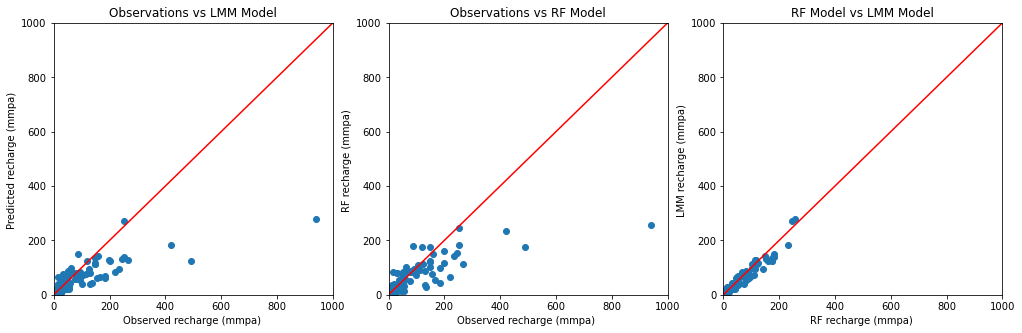

In [17]:
fig, axs = plt.subplots(1,3,figsize=(17,5))
axs = axs.flatten()
axs[0].plot(summary['Observations'], summary['BGS recharge'],marker='o',linestyle='')
axs[0].plot(range(0,1000), range(0,1000), 'r')
axs[0].set_xlabel('Observed recharge (mmpa) ')
axs[0].set_ylabel('Predicted recharge (mmpa) ')
axs[0].set_xlim([0,1000])
axs[0].set_title('Observations vs LMM Model')
axs[0].set_ylim([0,1000])

axs[1].plot(summary['Observations'], summary['RF recharge'],marker='o',linestyle='')
axs[1].plot(range(0,1000), range(0,1000), 'r')
axs[1].set_xlabel('Observed recharge (mmpa) ')
axs[1].set_ylabel('RF recharge (mmpa) ')
axs[1].set_xlim([0,1000])
axs[1].set_title('Observations vs RF Model')
axs[1].set_ylim([0,1000])

axs[2].plot(summary['RF recharge'], summary['BGS recharge'],marker='o',linestyle='')
axs[2].plot(range(0,1000), range(0,1000), 'r')
axs[2].set_xlabel('RF recharge (mmpa) ')
axs[2].set_ylabel('LMM recharge (mmpa) ')
axs[2].set_xlim([0,1000])
axs[2].set_title('RF Model vs LMM Model')
axs[2].set_ylim([0,1000])

# Visualise

In [2]:
import geemap
import ee
ee.Initialize()

# center over Africa
Map = geemap.Map(center=[0,40], zoom=2)

# add BGS recharge to the map
bgs_recharge_vis_params = {
    'min': 0,'max': 300, 
    'bands':'bgs_recharge', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}
ee_bgs_recharge = ee.Image('users/pazolka/BGS_Africa_recharge_05').rename('bgs_recharge')
Map.addLayer(ee_bgs_recharge, bgs_recharge_vis_params, 'LMM recharge', shown=False)
# fix for clean colorbar
bgs_recharge_vis_params['bands'] = 'LMM recharge (mmpa)'
Map.add_colorbar(bgs_recharge_vis_params)

In [2]:
rf_recharge_vis_params = {
    'min': 0,'max': 1, 
    'bands':'rf_recharge', 'palette': ['red', 'pink', 'white', 'lightblue', 'blue']
}
ee_rf_recharge_z = ee.Image('users/pazolka/Africa_ai').rename('rf_recharge')
Map.addLayer(ee_rf_recharge_z, rf_recharge_vis_params, 'AI', shown=False)

In [18]:
# add all training sample points to the layer
train_points = []

for (f,r,p) in zip(features, labels, train_predictions):
    entry = file[file['ID'] == f[-1]]
    lat = entry['Lat'].item()
    lon = entry['Long'].item()
    res = 10**p-10**r
    train_points.append(ee.Feature(ee.Geometry.Point(lon,lat), 
                             {'id': entry.ID.item(), 
                              'residual': res,
                              'residual_rel': res/10**r, 
                              'recharge_mmpa': entry.Recharge_mmpa.item(),
                              'model_recharge': 10**p,
                              'bgs_pcp_mmpa': entry.LTA_P_mmpa.item(),
                              'bgs_ai': entry.Aridity.item(),
                              'dem': entry.DEM.item()
                             }))
train_pc = ee.FeatureCollection(train_points);
Map.add_ee_layer(train_pc, {'color': 'lightgreen'}, 'Train sample points', shown=False)

In [19]:
# add train sample points with high negative residual to the layer
train_pc_lres = ee.FeatureCollection(train_pc.filter(ee.Filter.eq('recharge_mmpa', 0.1)))
Map.add_ee_layer(train_pc_lres, {'color': '#FF00FF'}, 'Zero-recharge points', shown=False)

# # add train sample points with high residual to the layer
# train_pc_hres = ee.FeatureCollection(train_pc.filter(ee.Filter.gt('residual', 100)))
# Map.add_ee_layer(train_pc_hres, {'color': '#FF0000'}, 'Train sample points: high residual', shown=False)

In [ ]:
# legend
legend_keys = ['Training and testing samples', 'Zero-recharge samples']
legend_colors = ['#90ee90', '#FF00FF']

Map.add_legend(legend_title="Groundwater recharge samples", legend_keys=legend_keys, legend_colors=legend_colors, position='bottomleft')

In [29]:
# import LTA precipitation raster
Map.add_raster('Recharge_files/Africa_bgs_LTA_AnnPrecip.tif', colormap='Spectral', bands=[1], layer_name='BGS Precip')

# import PET raster
#Map.add_raster('Recharge_files/Africa_bgs_LTA_AnnPET.tif', colormap='RdYlBu', bands=[1], layer_name='BGS PET')

# import aridity raster
#Map.add_raster('Recharge_files/Africa_bgs_aridity_index.tif', colormap='RdBu', bands=[1], layer_name='BGS Aridity')

# import NDVI raster
#ap.add_raster('Recharge_files/Africa_NDVI.tif', colormap='RdYlGn', bands=[1], layer_name='BGS NDVI')

# import resampled soil moisture (0-10cm) raster
#Map.add_raster('Low_res_data_05/LTA_FLDAS_Soil_moisture_Afr_05.tif', colormap='BrBG', bands=[1], layer_name='Soil moisture')

# import resampled LC raster
#Map.add_raster('Low_res_data_05/landcover_Afr_05.tif', colormap='BrBG', bands=[1], layer_name='Land cover')

In [ ]:
# # BGS recharge
#Map.add_raster('Low_res_data_05/BGS_Africa_recharge_05.tif', colormap='RdYlGn', bands=[1], layer_name='BGS recharge 0.5')

In [3]:
# visualise RF results
#Map.add_raster('RF_recharge.tif', colormap='RdYlGn', bands=[1], layer_name='RF recharge')
# add GEE for seamless inspection
rf_recharge_vis_params = {
    'min': 0,'max': 300, 
    'bands':'rf_recharge', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}
ee_rf_recharge = ee.Image('users/pazolka/RF_recharge').rename('rf_recharge')
Map.addLayer(ee_rf_recharge, rf_recharge_vis_params, 'RF recharge', shown=False)
# fix for clean colorbar
rf_recharge_vis_params['bands'] = 'RF recharge (mmpa)'
Map.add_colorbar(rf_recharge_vis_params)

In [24]:
rf_recharge_vis_params = {
    'min': 0.15,'max': 0.5, 
    'bands':'rf_recharge', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}

ee_rf_recharge = ee.Image('users/pazolka/Soil_moisture_Afr_01').rename('rf_recharge')
Map.addLayer(ee_rf_recharge, rf_recharge_vis_params, 'SM', shown=True)

In [ ]:
# visualise RF results
#Map.add_raster('RF_recharge.tif', colormap='RdYlGn', bands=[1], layer_name='RF recharge')
# add GEE for seamless inspection
rf_recharge_vis_params = {
    'min': 0,'max': 300, 
    'bands':'rf_recharge', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}
ee_rf_recharge_z = ee.Image('users/pazolka/RF_recharge_zero').rename('rf_recharge')
Map.addLayer(ee_rf_recharge_z, rf_recharge_vis_params, 'RF recharge zeros', shown=False)

rf_recharge_z_vis_params = {
    'min': -100,'max': 100, 
    'bands':'rf_recharge', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}
Map.addLayer(ee_rf_recharge_z.subtract(ee_rf_recharge).divide(ee_rf_recharge).multiply(100), rf_recharge_z_vis_params, 'Difference RF_zeros - RF/RF', shown=False)

In [ ]:
#Map.add_raster('RF_BGS_diff_recharge.tif', colormap='RdYlGn', bands=[1], layer_name='Recharge diff')
# create clean spatial difference with GEE
diff_recharge_vis_params = {
    'min': -100,'max': 100, 
    'bands':'diff_recharge', 'palette': ['red', 'yellow', 'blue']
}
ee_diff_recharge = ee_rf_recharge.subtract(ee_bgs_recharge).rename('diff_recharge')
Map.addLayer(ee_diff_recharge, diff_recharge_vis_params, 'diff recharge', shown=False)
# fix for clean colorbar
diff_recharge_vis_params['bands'] = 'RF - LMM recharge (mmpa)'
Map.add_colorbar(diff_recharge_vis_params, label="RF - LMM")

diff_recharge_rel_vis_params = {
    'min': -100,'max': 100, 
    'bands':'diff_recharge_rel', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}
ee_diff_recharge_rel = ee_diff_recharge.divide(ee_bgs_recharge).multiply(100).rename('diff_recharge_rel')
Map.addLayer(ee_diff_recharge_rel, diff_recharge_rel_vis_params, 'diff recharge (rel %)', shown=False)
# fix for clean colorbar
diff_recharge_rel_vis_params['bands'] = '(RF-LMM)/LMM (%)'
Map.add_colorbar(diff_recharge_rel_vis_params, label="(RF-LMM)/LMM * 100%")

In [ ]:
#Map.add_raster('RF_BGS_diff_recharge.tif', colormap='RdYlGn', bands=[1], layer_name='Recharge diff')
# create clean spatial difference with GEE
diff_recharge_vis_params = {
    'min': -100,'max': 100, 
    'bands':'diff_recharge', 'palette': ['red', 'yellow', 'blue']
}
ee_diff_recharge_z = ee_rf_recharge_z.subtract(ee_bgs_recharge).rename('diff_recharge')
Map.addLayer(ee_diff_recharge_z, diff_recharge_vis_params, 'diff recharge zero', shown=False)

diff_recharge_rel_vis_params = {
    'min': -100,'max': 100, 
    'bands':'diff_recharge_rel', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}
ee_diff_recharge_rel_z = ee_diff_recharge_z.divide(ee_bgs_recharge).multiply(100).rename('diff_recharge_rel')
Map.addLayer(ee_diff_recharge_rel_z, diff_recharge_rel_vis_params, 'diff recharge (rel %) zero', shown=False)

In [25]:
ee_rf_recharge_01 = ee.Image('users/pazolka/RF_recharge_01').rename('rf_recharge')
rf_recharge_vis_params = {
    'min': 0,'max': 300, 
    'bands':'rf_recharge', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}
Map.addLayer(ee_rf_recharge_01, rf_recharge_vis_params, 'RF recharge 01', shown=False)

In [3]:
# replicate BGS study
bgs_recharge_vis_params['bands'] = 'bgs_recharge'
ee_bgs_recharge_replica = ee.Image('users/pazolka/BGS_repl').rename('bgs_recharge')
Map.addLayer(ee_bgs_recharge_replica, bgs_recharge_vis_params, 'BGS replica', shown=False)

In [4]:
Map

Map(center=[0, 40], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
Map.add_shapefile("CRU_precip_CGIAR_AI_data/Africa_continent_shape.shp", style={"weight": 2, 'fill':False}, fill_colors=['white'], info_mode='on_hover')

In [ ]:
# with rasterio.open('Recharge_files/Africa_bgs_aridity_index.tif') as src:
#     print(np.unique(src.read()))
# pcp_vis = {'min': 0,'max': 2.7715831e+00}
# pcp_vis['bands'] = 'Aridity index'
# Map.add_colorbar(pcp_vis, cmap='terrain_r')